In [ ]:
### CARGA DE DATOS

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

In [45]:
# Cargar dataset HAR
train_file = "../data/train.h5"
test_file = "../data/test.h5"
labels_file = "../data/activity_labels.txt"

# Cargar etiquetas de actividades
activity_labels = pd.read_csv(labels_file, sep=" ", header=None, names=["id", "activity"])
print("Etiquetas de actividades:\n", activity_labels.to_string(index=False))

# Leer archivo H5 de entrenamiento
with h5py.File(train_file, "r") as f:
    channels = [
        np.array(f["body_acc_x"]),
        np.array(f["body_acc_y"]),
        np.array(f["body_acc_z"]),
        np.array(f["body_gyro_x"]),
        np.array(f["body_gyro_y"]),
        np.array(f["body_gyro_z"]),
        np.array(f["total_acc_x"]),
        np.array(f["total_acc_y"]),
        np.array(f["total_acc_z"]),
    ]
    y_train = np.array(f["y"]).astype(int)-1  # etiquetas

# Apilar para formar un único tensor (n_muestras, 128, 9)
X_train = np.stack(channels, axis=-1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# print(np.min(y_train), np.max(y_train))

# n, t, c = X_train.shape   # n = n_muestras, t=128, c=9
# Xn = X_train.reshape(n, t * c)
# print("Xn shape:", Xn.shape)


#############################################################
#############################################################
import h5py

with h5py.File(test_file, "r") as f:
    print(list(f.keys()))

with h5py.File(train_file, "r") as f:
    print(list(f.keys()))

with h5py.File(test_file, "r") as f:
    channels_test = [
        np.array(f["body_acc_x"]),
        np.array(f["body_acc_y"]),
        np.array(f["body_acc_z"]),
        np.array(f["body_gyro_x"]),
        np.array(f["body_gyro_y"]),
        np.array(f["body_gyro_z"]),
        np.array(f["total_acc_x"]),
        np.array(f["total_acc_y"]),
        np.array(f["total_acc_z"]),
    ]
    #y_test = np.array(f["y"]).astype(int)-1  # etiquetas en 0..5

# Apilar canales → tensor (n_muestras, 128, 9)
X_test = np.stack(channels_test, axis=-1)
print("X_test shape:", X_test.shape)
#print("y_test shape:", y_test.shape)



Etiquetas de actividades:
  id           activity
  1            WALKING
  2   WALKING_UPSTAIRS
  3 WALKING_DOWNSTAIRS
  4            SITTING
  5           STANDING
  6             LAYING
X_train shape: (7352, 128, 9)
y_train shape: (7352,)
['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y']
X_test shape: (2947, 128, 9)


## Regression Logistica

In [89]:
import numpy as np

# -----------------------
# utilidades
# -----------------------
def to_one_hot(y, K):
    """Convierte etiquetas y: (n,) a one-hot (n,K)"""
    n = y.size
    Y = np.zeros((n, K), dtype=float)
    Y[np.arange(n), y.astype(int)] = 1.0
    return Y

def softmax_rows(Z):
    """Softmax por fila con estabilidad numérica"""
    Z_max = np.max(Z, axis=1, keepdims=True)
    Z_stable = Z - Z_max
    expZ = np.exp(Z_stable)
    P = expZ / np.sum(expZ, axis=1, keepdims=True)
    return P

def predict_proba(X, W, b):
    """X: (n,d), W: (d,K), b: (1,K) -> devuelve (n,K)"""
    Z = X @ W + b  # (n,K)
    P = softmax_rows(Z)
    return P

def predict(X, W, b):
    P = predict_proba(X, W, b)
    return np.argmax(P, axis=1)

def compute_cost(X, y, W, b, l2_lambda=0.0):
    n = X.shape[0]
    K = W.shape[1]
    P = predict_proba(X, W, b)  # (n,K)
    Y = to_one_hot(y, K)
    eps = 1e-12
    loss = -np.sum(Y * np.log(P + eps)) / n
    if l2_lambda > 0:
        loss += (l2_lambda / (2.0 * n)) * np.sum(W**2)
    return loss


In [90]:
def train_softmax_batchGD(X, y, K, lr=0.1, iters=1000, l2_lambda=0.0, verbose=False):
    """
    X: (n,d), y: (n,), K: número de clases
    Devuelve: W (d,K), b (1,K), J_hist (iters,)
    """
    n, d = X.shape
    rng = np.random.RandomState(0)
    W = rng.normal(scale=0.01, size=(d, K))  # (d,K)
    b = np.zeros((1, K))                     # (1,K)
    Y = to_one_hot(y, K)                     # (n,K)
    J_hist = np.zeros(iters)

    for it in range(iters):
        P = predict_proba(X, W, b)           # (n,K)
        # gradientes
        dW = (X.T @ (P - Y)) / n             # (d,K)
        db = np.sum(P - Y, axis=0, keepdims=True) / n  # (1,K)

        if l2_lambda > 0:
            dW += (l2_lambda / n) * W

        # actualización
        W -= lr * dW
        b -= lr * db

        # costo
        J_hist[it] = compute_cost(X, y, W, b, l2_lambda)
        if verbose and (it % (iters//10 + 1) == 0):
            print(f"Iter {it}/{iters} - cost: {J_hist[it]:.6f}")

    return W, b, J_hist


In [91]:
# 1) aplanar
X_flat = X_train.reshape(X_train.shape[0], -1)  # (7352, 128*9 = 1152)

# 2) opcional: estandarizar por feature
mu = np.mean(X_flat, axis=0, keepdims=True)
sigma = np.std(X_flat, axis=0, keepdims=True)
sigma[sigma == 0] = 1.0
Xn_s = (X_flat - mu) / sigma  # (7352, 1152)

# 3) entrenar
K = 6
W, b, J_hist = train_softmax_batchGD(Xn_s, y_train, K, lr=0.1, iters=1500, l2_lambda=0.01, verbose=True)

# 4) predecir
y_pred = predict(Xn_s, W, b)



Iter 0/1500 - cost: 1.438530
Iter 151/1500 - cost: 0.837970
Iter 302/1500 - cost: 0.816680
Iter 453/1500 - cost: 0.804191
Iter 604/1500 - cost: 0.795108
Iter 755/1500 - cost: 0.787903
Iter 906/1500 - cost: 0.781918
Iter 1057/1500 - cost: 0.776800
Iter 1208/1500 - cost: 0.772336
Iter 1359/1500 - cost: 0.768383


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


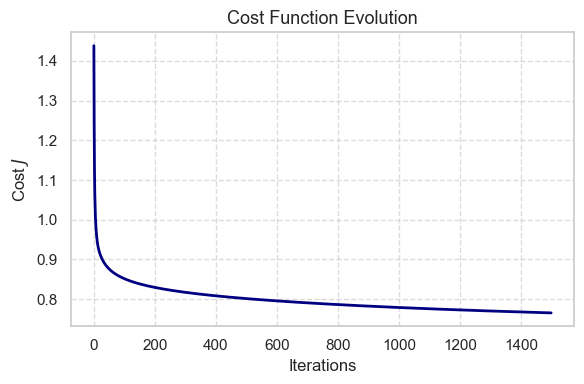

In [96]:
import matplotlib.pyplot as plt

# Create figure with publication style
plt.figure(figsize=(6,4))  # compact size for papers
plt.plot(J_hist, color="navy", linewidth=2)

# Labels with clear font
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Cost $J$", fontsize=12)
plt.title("Cost Function Evolution", fontsize=13)

# Style improvements
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Save in EPS for LaTeX
plt.savefig("costLogistic.eps", format="eps", dpi=300)

plt.show()


In [93]:
import numpy as np

def accuracy(y_true, y_pred):
    """
    Accuracy = (n correctas) / (n total)
    """
    return np.sum(y_true == y_pred) / y_true.size

def confusion_matrix(y_true, y_pred, K):
    """
    Devuelve matriz de confusión (KxK)
    filas = clases reales, columnas = clases predichas
    """
    cm = np.zeros((K, K), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def f1_score_per_class(y_true, y_pred, K):
    """
    Calcula F1-score para cada clase y devuelve vector de longitud K
    """
    cm = confusion_matrix(y_true, y_pred, K)
    f1 = np.zeros(K)
    for k in range(K):
        TP = cm[k, k]
        FP = np.sum(cm[:, k]) - TP
        FN = np.sum(cm[k, :]) - TP
        if TP + FP == 0 or TP + FN == 0:
            f1[k] = 0.0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            if precision + recall == 0:
                f1[k] = 0.0
            else:
                f1[k] = 2 * (precision * recall) / (precision + recall)
    return f1


# aplanar y estandarizar
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# usar la media y sigma del training
X_train_s = (X_train_flat - mu) / sigma
X_test_s  = (X_test_flat - mu) / sigma

# predecir
y_pred_train = predict(X_train_s, W, b)
y_pred_test  = predict(X_test_s, W, b)

# Accuracy
acc_train = accuracy(y_train, y_pred_train)
#acc_test  = accuracy(y_test, y_pred_test)  # si tus y_test también van 1..6

print("Accuracy train:", acc_train)
#print("Accuracy test:", acc_test)

# F1-score
f1_train = f1_score_per_class(y_train, y_pred_train, K)
#f1_test  = f1_score_per_class(y_test - 1, y_pred_test, K)

print("F1-score por clase (train):", f1_train)
#print("F1-score por clase (test) :", f1_test)

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train, K)
#cm_test  = confusion_matrix(y_test - 1, y_pred_test, K)

print("Confusion matrix (train):\n", cm_train)
#print("Confusion matrix (test):\n", cm_test)


#####################################################
# Crear un DataFrame con las predicciones
import pandas as pd
results = pd.DataFrame({
    'ID': np.arange(1, len(X_test_s) + 1),  # +1 para que tenga la misma longitud
    'Prediction': y_pred_test+1
})

results.to_csv("KaggleUpload.csv", index=False)

Accuracy train: 0.7290533188248096
F1-score por clase (train): [0.56703911 0.71774194 0.61040462 0.82600382 0.59083728 1.        ]
Confusion matrix (train):
 [[ 609  108  149   25  335    0]
 [  83  801   54   22  113    0]
 [ 140   63  528   34  221    0]
 [  11    5    3 1080  187    0]
 [  79  182   10  168  935    0]
 [   0    0    0    0    0 1407]]
